In [1]:
import pandas as pd
import numpy as np
import sklearn
import os
import librosa
import torch
import math
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,f1_score,confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split


In [2]:
path=r'C:\Users\deniz\.cache\kagglehub\datasets\chrisfilo\urbansound8k\versions\1'

In [3]:
all_folders = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]
train_folders, test_folders = train_test_split(all_folders,test_size=0.2,train_size=0.8,random_state=42,)

print(train_folders)
print(test_folders)


['fold5', 'fold1', 'fold7', 'fold2', 'fold9', 'fold4', 'fold3', 'fold6']
['fold8', 'fold10']


In [4]:
df_UrbanSounds=pd.read_csv(path+"/UrbanSound8K.csv")
df_UrbanSounds.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [5]:
def load_folder_spectrograms(folder_name):
    # Using the librosa library convert sounds to spectograms of given folder
    folder_path = os.path.join(path, folder_name)
    rows = []

    for root, _, files in os.walk(folder_path):
        for file in files:
            # 
            audio_path = os.path.join(root, file)
            signal, sr = librosa.load(audio_path)
            mel = librosa.feature.melspectrogram(y=signal, sr=sr)
            mel_db = librosa.power_to_db(mel, ref=np.max)
            rows.append(
                {
                    "slice_file_name": file,
                    "file_path": audio_path,
                    "spectrogram": mel_db,
                }
            )

    return rows

train_records=[]
test_records=[]

# Load all folders
for folder in train_folders:
    folder_rows = load_folder_spectrograms(folder)
    train_records.extend(folder_rows)

for folder in test_folders:
    folder_rows = load_folder_spectrograms(folder)
    test_records.extend(folder_rows)

train_df = pd.DataFrame(train_records)
test_df = pd.DataFrame(test_records)




c:\kod\.venv\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
c:\kod\.venv\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
c:\kod\.venv\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(


In [6]:
# Add the spectograms to df
train_df = train_df.merge(df_UrbanSounds,on="slice_file_name",how="left",suffixes=("", "_metadata"),)
train_df.head()



,slice_file_name,file_path,spectrogram,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,C:\Users\deniz\.cache\kagglehub\datasets\chris...,"[[-72.605446, -66.374306, -65.6224, -72.3324, ...",100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,C:\Users\deniz\.cache\kagglehub\datasets\chris...,"[[-14.085968, -8.141104, -11.648771, -13.98639...",100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,C:\Users\deniz\.cache\kagglehub\datasets\chris...,"[[-23.529215, -14.483944, -8.977369, -10.78972...",100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,C:\Users\deniz\.cache\kagglehub\datasets\chris...,"[[-16.638777, -16.541023, -21.979187, -20.4650...",100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,C:\Users\deniz\.cache\kagglehub\datasets\chris...,"[[-9.874212, -6.784529, -8.704067, -9.477375, ...",100263,68.5,72.500000,1,5,2,children_playing


In [7]:
test_df = test_df.merge(df_UrbanSounds,on="slice_file_name",how="left",suffixes=("", "_metadata"),)
print(test_df["spectrogram"][0].shape)

(128, 109)


In [8]:
def spectrogram_to_feature(spec):
    return spec.mean(axis=1)


train_df["feature_vector"] = train_df["spectrogram"].apply(spectrogram_to_feature)
test_df["feature_vector"] = test_df["spectrogram"].apply(spectrogram_to_feature)

X_train = np.stack(train_df["feature_vector"].to_list()).astype(np.float32)
y_train = train_df["classID"].astype(int).to_numpy()

X_test = np.stack(test_df["feature_vector"].to_list()).astype(np.float32)
y_test = test_df["classID"].astype(int).to_numpy()

X_train.shape, y_train.shape


((7089, 128), (7089,))

In [9]:
class MLP:
    def __init__(self, input_size, hidden_sizes, output_size, activation="sigmoid"):
        if isinstance(hidden_sizes, int):
            hidden_sizes = [hidden_sizes]
        # Define layer sizes
        self.layer_sizes = [input_size] + list(hidden_sizes) + [output_size]
        self.num_layers = len(self.layer_sizes) - 1  # excludes input layer

        # Small random initialisation for stability
        self.weights = []
        self.biases = []
        for in_size, out_size in zip(self.layer_sizes[:-1], self.layer_sizes[1:]):
            self.weights.append(np.random.randn(in_size, out_size) * 0.01)
            self.biases.append(np.zeros((1, out_size)))

        self.set_activation(activation)

    def set_activation(self, activation_name: str):
        # Set activation function and its derivative
        activation_name = activation_name.lower()
        if activation_name == "sigmoid":
            self.activation_name = "sigmoid"
            self.activation_fn = self.sigmoid
            self.activation_derivative = self.sigmoid_derivative
        elif activation_name == "tanh":
            self.activation_name = "tanh"
            self.activation_fn = self.tanh
            self.activation_derivative = self.tanh_derivative
        else:
            raise ValueError("Unsupported activation. Use 'sigmoid' or 'tanh'.")
    # Define activation functions and their derivatives
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, activated_output):
        return activated_output * (1 - activated_output)

    def tanh(self, x):
        return np.tanh(x)

    def tanh_derivative(self, activated_output):
        return 1 - np.square(activated_output)
     
    def softmax(self, x):
        x_stable = x - np.max(x, axis=1, keepdims=True)
        # Compute softmax stable way
        exp_x = np.exp(x_stable)
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def log_loss(self, y_true, y_pred):
        # Compute the cross-entropy loss
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        y_true = np.array(y_true)

        if y_true.ndim == 1 or (y_true.ndim == 2 and y_true.shape[1] == 1):
            # Convert to one-hot encoding
            n_samples = y_true.shape[0]
            n_classes = y_pred.shape[1]
            y_true_onehot = np.zeros((n_samples, n_classes))
            y_true_onehot[np.arange(n_samples), y_true.flatten()] = 1
            y_true = y_true_onehot
        # Calculate log loss
        loss = -np.mean(np.sum(y_true * np.log(y_pred), axis=1))
        return loss

    def forward(self, X):
        activations = [X]
        pre_activations = []
        # Forward pass through all layers for arbitrary depth 
        # Using softmax in the output layer
        for layer_idx in range(self.num_layers):
            t = np.dot(activations[-1], self.weights[layer_idx]) + self.biases[layer_idx]
            pre_activations.append(t)

            if layer_idx == self.num_layers - 1:
                a = self.softmax(t)
            else:
                a = self.activation_fn(t)
            activations.append(a)
        # Store for backpropagation
        self.layer_inputs = pre_activations
        self.layer_outputs = activations
        return activations[-1]

    def backward(self, X, y_true, output, learning_rate):
        n_samples = X.shape[0]
        # Convert y_true to one-hot encoding if necessary
        y_true = np.array(y_true)
        if y_true.ndim == 1 or (y_true.ndim == 2 and y_true.shape[1] == 1):
            y_onehot = np.zeros_like(output)
            y_onehot[np.arange(n_samples), y_true.flatten()] = 1
        else:
            y_onehot = y_true

        # Gradient of cross-entropy with softmax
        current_error = (output - y_onehot) / n_samples

        for layer_idx in reversed(range(self.num_layers)):
            activation_prev = self.layer_outputs[layer_idx]

            # Compute gradients
            grad_w = np.dot(activation_prev.T, current_error)
            grad_b = np.sum(current_error, axis=0, keepdims=True)

            # Update weights and biases
            self.weights[layer_idx] -= learning_rate * grad_w
            self.biases[layer_idx] -= learning_rate * grad_b

            # Backpropagate the error to the previous layer
            if layer_idx > 0:
                prev_activation = self.layer_outputs[layer_idx]
                current_error = np.dot(current_error, self.weights[layer_idx].T)
                current_error *= self.activation_derivative(prev_activation)

    def _iterate_batches(self, X, y, batch_size, shuffle=True):
        # Generator to yield mini-batches for given size
        indices = np.arange(X.shape[0])
        if shuffle:
            np.random.shuffle(indices)
        for start in range(0, X.shape[0], batch_size):
            end = start + batch_size
            batch_idx = indices[start:end]
            yield X[batch_idx], y[batch_idx]

    def train(self, X, y, epochs, learning_rate, batch_size):
        history=[]
        for epoch in range(epochs):
            for X_batch, y_batch in self._iterate_batches(X, y, batch_size):
                output = self.forward(X_batch)
                self.backward(X_batch, y_batch, output, learning_rate)

            if (epoch + 1) % 20 == 0:
                preds = self.forward(X)
                loss = self.log_loss(y, preds)
                history.append([loss,epoch])
        return history
    def predict(self, X):
        # Predict class labels for given input
        output = self.forward(X)
        return np.argmax(output, axis=1)

In [10]:
num_classes = len(np.unique(y_train))
model_sig_1 = MLP(input_size=X_train.shape[1],hidden_sizes=[256],output_size=num_classes,activation="sigmoid")
model_sig_2 = MLP(input_size=X_train.shape[1],hidden_sizes=[256,128],output_size=num_classes,activation="sigmoid")
model_tan_1 = MLP(input_size=X_train.shape[1],hidden_sizes=[256],output_size=num_classes,activation="tanh")
model_tan_2 = MLP(input_size=X_train.shape[1],hidden_sizes=[256,128],output_size=num_classes,activation="tanh")


In [11]:
hist_sig_1=[]
for batch_size in [16,32,64,128]:
    for learning_rate in [0.005,0.01,0.02]:
        history = model_sig_1.train(X_train, y_train, epochs=50, learning_rate=learning_rate, batch_size=batch_size)
        pred = model_sig_1.predict(X_test)
        accu=accuracy_score(y_test,pred)
        f1=f1_score(y_test,pred,average="weighted")
        hist_sig_1.append({
            "batch_size":batch_size,
            "learning_rate":learning_rate,
            "activation":model_sig_1.activation_name,
            "f1":f1,
            "accuracy":accu}
        )

C:\Users\deniz\AppData\Local\Temp\ipykernel_35492\192041477.py:33: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
C:\Users\deniz\AppData\Local\Temp\ipykernel_35492\192041477.py:33: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
C:\Users\deniz\AppData\Local\Temp\ipykernel_35492\192041477.py:33: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
C:\Users\deniz\AppData\Local\Temp\ipykernel_35492\192041477.py:33: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
C:\Users\deniz\AppData\Local\Temp\ipykernel_35492\192041477.py:33: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
C:\Users\deniz\AppData\Local\Temp\ipykernel_35492\192041477.py:33: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
C:\Users\deniz\AppData\Local\Temp\ipykernel_35492\192041477.py:33: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
C:\Users\deni

In [12]:
hist_sig_2=[]
for batch_size in [16,32,64,128]:
    for learning_rate in [0.005,0.01,0.02]:
        history = model_sig_2.train(X_train, y_train, epochs=50, learning_rate=learning_rate, batch_size=batch_size)
        pred = model_sig_2.predict(X_test)
        accu=accuracy_score(y_test,pred)
        f1=f1_score(y_test,pred,average="weighted")
        hist_sig_2.append({
            "batch_size":batch_size,
            "learning_rate":learning_rate,
            "activation":model_sig_2.activation_name,
            "f1":f1,
            "accuracy":accu}
        )

C:\Users\deniz\AppData\Local\Temp\ipykernel_35492\192041477.py:33: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
C:\Users\deniz\AppData\Local\Temp\ipykernel_35492\192041477.py:33: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
C:\Users\deniz\AppData\Local\Temp\ipykernel_35492\192041477.py:33: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
C:\Users\deniz\AppData\Local\Temp\ipykernel_35492\192041477.py:33: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
C:\Users\deniz\AppData\Local\Temp\ipykernel_35492\192041477.py:33: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
C:\Users\deniz\AppData\Local\Temp\ipykernel_35492\192041477.py:33: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
C:\Users\deniz\AppData\Local\Temp\ipykernel_35492\192041477.py:33: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
C:\Users\deni

In [13]:
hist_tan_1=[]
for batch_size in [16,32,64,128]:
    for learning_rate in [0.005,0.01,0.02]:
        history = model_tan_1.train(X_train, y_train, epochs=50, learning_rate=learning_rate, batch_size=batch_size)
        pred = model_tan_1.predict(X_test)
        accu=accuracy_score(y_test,pred)
        f1=f1_score(y_test,pred,average="weighted")
        hist_tan_1.append({
            "batch_size":batch_size,
            "learning_rate":learning_rate,
            "activation":model_tan_2.activation_name,
            "f1":f1,
            "accuracy":accu}
        )

In [14]:
hist_tan_2=[]
for batch_size in [16,32,64,128]:
    for learning_rate in [0.005,0.01,0.02]:
        history = model_tan_2.train(X_train, y_train, epochs=50, learning_rate=learning_rate, batch_size=batch_size)
        pred = model_tan_2.predict(X_test)
        accu=accuracy_score(y_test,pred)
        f1=f1_score(y_test,pred,average="weighted")
        hist_tan_2.append({
            "batch_size":batch_size,
            "learning_rate":learning_rate,
            "activation":model_tan_2.activation_name,
            "f1":f1,
            "accuracy":accu}
        )

In [15]:
df_hist=pd.DataFrame(hist_sig_1+hist_sig_2+hist_tan_1+hist_tan_2)
print(df_hist)

    batch_size  learning_rate activation        f1  accuracy
0           16          0.005    sigmoid  0.315786  0.359708
1           16          0.010    sigmoid  0.217509  0.303713
2           16          0.020    sigmoid  0.144921  0.242848
3           32          0.005    sigmoid  0.454969  0.472307
4           32          0.010    sigmoid  0.402795  0.423007
5           32          0.020    sigmoid  0.228222  0.308582
6           64          0.005    sigmoid  0.474546  0.493609
7           64          0.010    sigmoid  0.489584  0.506391
8           64          0.020    sigmoid  0.441901  0.459525
9          128          0.005    sigmoid  0.462604  0.487523
10         128          0.010    sigmoid  0.496045  0.513694
11         128          0.020    sigmoid  0.442906  0.463786
12          16          0.005    sigmoid  0.293489  0.370055
13          16          0.010    sigmoid  0.195228  0.278150
14          16          0.020    sigmoid  0.021864  0.110164
15          32          

In [16]:
for item in hist_sig_1 + hist_tan_1:
    item['Model'] = '1 Layer'
for item in hist_sig_2 + hist_tan_2:
    item['Model'] = '2 Layers'

df_hist = pd.DataFrame(hist_sig_1 + hist_sig_2 + hist_tan_1 + hist_tan_2)

# Reorder columns for better readability
cols = ['Model', 'activation', 'batch_size', 'learning_rate', 'accuracy', 'f1']
df_hist = df_hist[cols]

# Sort by Accuracy to see best results at the top
df_hist_sorted = df_hist.sort_values(by='f1', ascending=False)

In [17]:
print(df_hist_sorted)

       Model activation  batch_size  learning_rate  accuracy        f1
10   1 Layer    sigmoid         128          0.010  0.513694  0.496045
7    1 Layer    sigmoid          64          0.010  0.506391  0.489584
6    1 Layer    sigmoid          64          0.005  0.493609  0.474546
9    1 Layer    sigmoid         128          0.005  0.487523  0.462604
3    1 Layer    sigmoid          32          0.005  0.472307  0.454969
11   1 Layer    sigmoid         128          0.020  0.463786  0.442906
8    1 Layer    sigmoid          64          0.020  0.459525  0.441901
4    1 Layer    sigmoid          32          0.010  0.423007  0.402795
0    1 Layer    sigmoid          16          0.005  0.359708  0.315786
12  2 Layers    sigmoid          16          0.005  0.370055  0.293489
23  2 Layers    sigmoid         128          0.020  0.318320  0.248742
20  2 Layers    sigmoid          64          0.020  0.345100  0.247810
15  2 Layers    sigmoid          32          0.005  0.322581  0.240364
22  2 

The first important thing to look for is sigmoid. Sigmoid outperformed tanh in most cases. Top 10 models are also full sigmoid. Top 10 models are also full 1 Layer. So 1 layer is better than 2 layers. For batch size 16 is too small best models use 64 and 128 but 32 is also not bad so generallay big batch size is better.

In [18]:
MAX_TIME_FRAMES = 128
N_MELS = 128

def pad_or_truncate(spec, max_len=MAX_TIME_FRAMES):

    if spec.shape[1] < max_len:
        # Pad with zeros on the right
        pad_width = max_len - spec.shape[1]
        # ((top, bottom), (left, right)) -> ((0,0), (0, pad_width))
        padded_spec = np.pad(spec, ((0, 0), (0, pad_width)), mode='constant')
        return padded_spec
    else:
        # Truncate (cut off the end)
        return spec[:, :max_len]
# Get the padded/truncated spectrograms
X_train_cnn_list = [pad_or_truncate(spec) for spec in train_df['spectrogram']]
X_test_cnn_list = [pad_or_truncate(spec) for spec in test_df['spectrogram']]

X_train_cnn_np = np.array(X_train_cnn_list)
X_test_cnn_np = np.array(X_test_cnn_list)

# Add the "Channel" dimension
X_train_cnn_np = X_train_cnn_np[:, np.newaxis, :, :]
X_test_cnn_np = X_test_cnn_np[:, np.newaxis, :, :]

y_train_cnn_np = train_df['classID'].values
y_test_cnn_np = test_df['classID'].values

tensor_x_train = torch.Tensor(X_train_cnn_np)
tensor_y_train = torch.LongTensor(y_train_cnn_np)

tensor_x_test = torch.Tensor(X_test_cnn_np)
tensor_y_test = torch.LongTensor(y_test_cnn_np)

train_dataset = TensorDataset(tensor_x_train, tensor_y_train)
test_dataset = TensorDataset(tensor_x_test, tensor_y_test)



In [19]:
num_classes = len(np.unique(y_train_cnn_np))
# I will use this batch size for all models
BATCH_SIZE = 32

# I used DataLoader since giving every input at the same time is bad
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(tensor_x_train.shape)


torch.Size([7089, 1, 128, 128])


In [20]:
class CNN_model(nn.Module):
    def __init__(self, input_shape, conv_layers, fc_layers, num_classes, activation="relu"):
        super(CNN_model, self).__init__()
        self.conv_layers = nn.ModuleList()
        self.fc_layers = nn.ModuleList()
        
        in_channels = input_shape[0]
        if activation=="relu":
            activation_fn = nn.ReLU
        if activation=="tanh":
            activation_fn = nn.Tanh
        # Same for everyery cnn layer
        for out_channels in conv_layers:
            self.conv_layers.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                    activation_fn(),
                    nn.MaxPool2d(kernel_size=2, stride=2)
                )
            )
            in_channels = out_channels 

        # We pass a dummy tensor through the conv layers to determine the size dynamically
        with torch.no_grad():
            dummy_input = torch.zeros(1, *input_shape)
            x = dummy_input
            for layer in self.conv_layers:
                x = layer(x)
            self.flatten_size = x.view(1, -1).size(1)

        in_features = self.flatten_size
        
        # Flattened cnn outputs for fc layers
        for hidden_units in fc_layers:
            self.fc_layers.append(
                nn.Sequential(
                    nn.Linear(in_features, hidden_units),
                    activation_fn(),
                )
            )
            in_features = hidden_units 

        # Use the output of fc 
        self.output_layer = nn.Linear(in_features, num_classes)

    def forward(self, x):
        # Pass through Conv layers
        for layer in self.conv_layers:
            x = layer(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Pass through fc layers
        for layer in self.fc_layers:
            x = layer(x)
            
        # Output
        x = self.output_layer(x)
        return x

    def initialize_weights(self):
        # Give random numbers to the wirghts
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

Using device: cuda
Epoch 1/20, Loss: 346.7484
Epoch 2/20, Loss: 43.0046
Epoch 3/20, Loss: 30.9250
Epoch 4/20, Loss: 20.1064
Epoch 5/20, Loss: 20.0794
Epoch 6/20, Loss: 11.2390
Epoch 7/20, Loss: 2.1746
Epoch 8/20, Loss: 2.0886
Epoch 9/20, Loss: 2.0417
Epoch 10/20, Loss: 2.0041
Epoch 11/20, Loss: 1.9888
Epoch 12/20, Loss: 2.0494
Epoch 13/20, Loss: 2.0766
Epoch 14/20, Loss: 1.9702
Epoch 15/20, Loss: 1.9436
Epoch 16/20, Loss: 1.9728
Epoch 17/20, Loss: 2.0181
Epoch 18/20, Loss: 2.1399
Epoch 19/20, Loss: 2.1231
Epoch 20/20, Loss: 2.1701


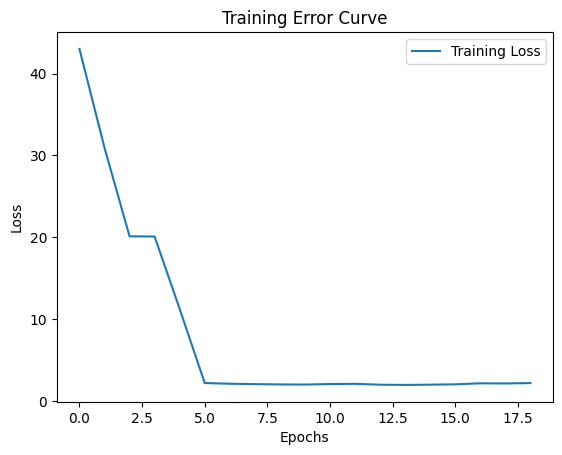


Test Accuracy: 0.1631


<Figure size 1200x1000 with 0 Axes>

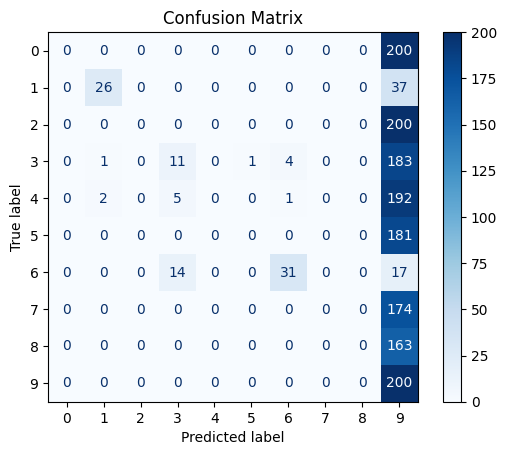

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 1 cnn 1 fc layer model
model = CNN_model(
    input_shape=(1, 128, 128),
    conv_layers=[32],
    fc_layers=[128],
    num_classes=10,
    activation="relu"
).to(device)

model.initialize_weights()

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

# Training
train_losses = []
model.train()

epochs=20
# Training loop is tring the random batch than gets the error of cross enthropy gets loss derivative than 
# Adjusts the weights than writes the error of current
for epoch in range(epochs):
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")

plt.plot(train_losses[1:], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Error Curve')
plt.legend()
plt.show()

model.eval() 
all_preds = []
all_labels = []

# Copy of the evalute of models
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)
        
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = accuracy_score(all_labels, all_preds)
print(f"\nTest Accuracy: {test_accuracy:.4f}")

classes = np.unique(all_labels)

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(12, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()

1 cnn 1 fc layer models performs very bad. It performs worse than mlp model. 0.14 accuracy is a a bit better than random %10 so this part is not useful.

Using device: cuda
Epoch 1/20, Loss: 43.8818
Epoch 2/20, Loss: 1.3380
Epoch 3/20, Loss: 0.8154
Epoch 4/20, Loss: 0.5428
Epoch 5/20, Loss: 0.3830
Epoch 6/20, Loss: 0.2568
Epoch 7/20, Loss: 0.2000
Epoch 8/20, Loss: 0.1459
Epoch 9/20, Loss: 0.0802
Epoch 10/20, Loss: 0.0573
Epoch 11/20, Loss: 0.0857
Epoch 12/20, Loss: 0.1194
Epoch 13/20, Loss: 0.0395
Epoch 14/20, Loss: 0.0366
Epoch 15/20, Loss: 0.0131
Epoch 16/20, Loss: 0.0114
Epoch 17/20, Loss: 0.0157
Epoch 18/20, Loss: 0.1422
Epoch 19/20, Loss: 0.1357
Epoch 20/20, Loss: 0.0664


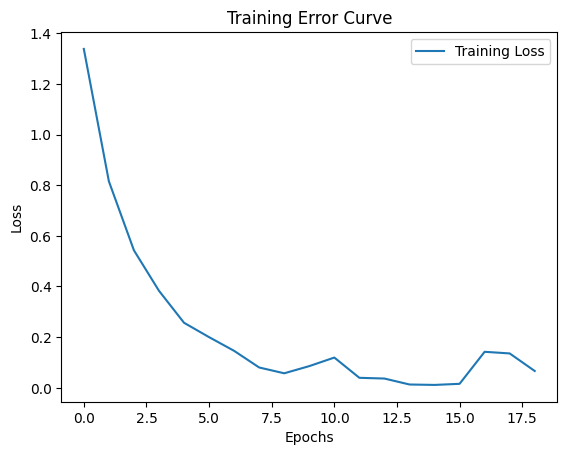


Test Accuracy: 0.5685


<Figure size 1200x1000 with 0 Axes>

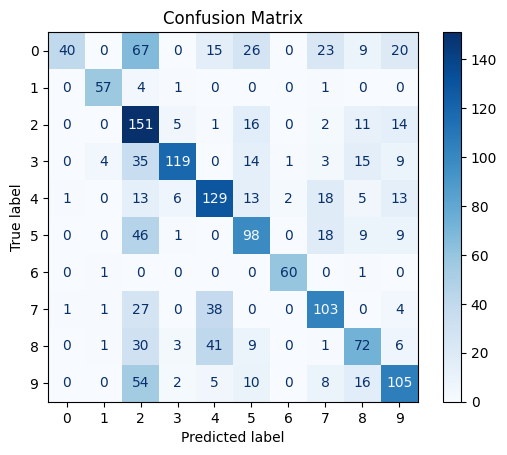

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 2 cnn 2 fc layer model
model = CNN_model(
    input_shape=(1, 128, 128),
    conv_layers=[16,32],
    fc_layers=[128,128],
    num_classes=10,
    activation="relu"
).to(device)

model.initialize_weights()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
train_losses = []
model.train()
epochs=20
# Same training loop 
for epoch in range(epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")

plt.plot(train_losses[1:], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Error Curve')
plt.legend()
plt.show()

model.eval() 
all_preds = []
all_labels = []

# Disable gradient evaluation
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)
        
        # Get predictions 
        _, preds = torch.max(outputs, 1)
        
        # Store predictions need to use CPU
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy
test_accuracy = accuracy_score(all_labels, all_preds)
print(f"\nTest Accuracy: {test_accuracy:.4f}")

classes = np.unique(all_labels)
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(12, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()

2 cnn 2 fc layers with relu got 0.64 accuracy. This is much better and it is useful.

Using device: cuda
Epoch 1/20, Loss: 2.0510
Epoch 2/20, Loss: 1.1136
Epoch 3/20, Loss: 0.6858
Epoch 4/20, Loss: 0.4227
Epoch 5/20, Loss: 0.2686
Epoch 6/20, Loss: 0.1533
Epoch 7/20, Loss: 0.0835
Epoch 8/20, Loss: 0.0412
Epoch 9/20, Loss: 0.0195
Epoch 10/20, Loss: 0.0118
Epoch 11/20, Loss: 0.0082
Epoch 12/20, Loss: 0.0065
Epoch 13/20, Loss: 0.0055
Epoch 14/20, Loss: 0.0048
Epoch 15/20, Loss: 0.0044
Epoch 16/20, Loss: 0.0036
Epoch 17/20, Loss: 0.0040
Epoch 18/20, Loss: 0.0034
Epoch 19/20, Loss: 0.0034
Epoch 20/20, Loss: 0.0026


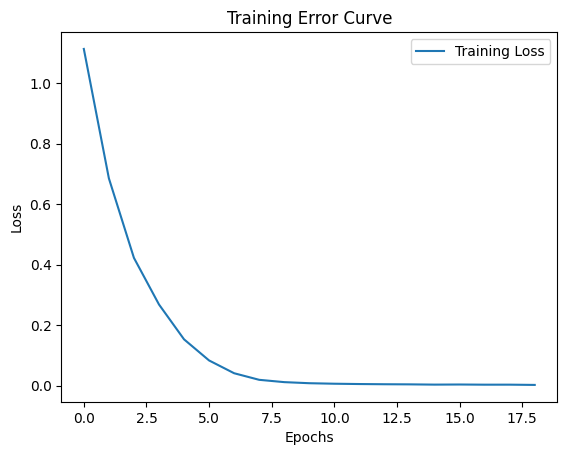


Test Accuracy: 0.6586


<Figure size 1200x1000 with 0 Axes>

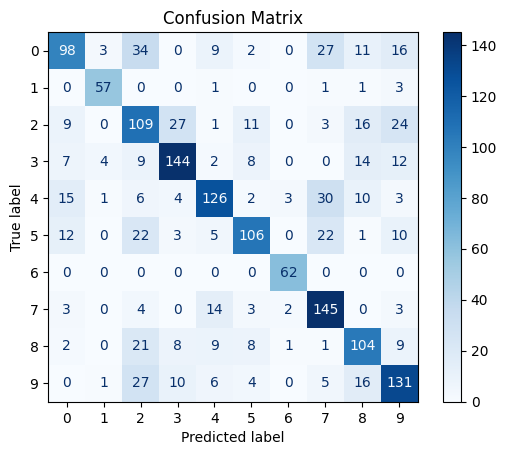

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 2 cnn 2 fc layer model with tanh activation
model = CNN_model(
    input_shape=(1, 128, 128),
    conv_layers=[16,32],
    fc_layers=[128,128],
    num_classes=10,
    activation="tanh"
).to(device)

model.initialize_weights()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

# Training
train_losses = []
model.train()

epochs=20
# Training loop is tring the random batch than gets the error of cross enthropy gets loss derivative than 
# Adjusts the weights than writes the error of current
for epoch in range(epochs):
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")

plt.plot(train_losses[1:], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Error Curve')
plt.legend()
plt.show()


model.eval() 
all_preds = []
all_labels = []

# Copy of the evalute of models
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)
        
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = accuracy_score(all_labels, all_preds)
print(f"\nTest Accuracy: {test_accuracy:.4f}")

classes = np.unique(all_labels)

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(12, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()

2 cnn 2 fc with tanh got a bit better score than relu. 0.66 is 0.02 better than relu but not significant. Still useful to look.

Using device: cuda
Epoch 1/60, Loss: 6.4269
Epoch 2/60, Loss: 1.7693
Epoch 3/60, Loss: 1.5977
Epoch 4/60, Loss: 1.4195
Epoch 5/60, Loss: 1.2604
Epoch 6/60, Loss: 1.0674
Epoch 7/60, Loss: 0.9278
Epoch 8/60, Loss: 0.8039
Epoch 9/60, Loss: 0.7045
Epoch 10/60, Loss: 0.6454
Epoch 11/60, Loss: 0.5504
Epoch 12/60, Loss: 0.4298
Epoch 13/60, Loss: 0.4035
Epoch 14/60, Loss: 0.3979
Epoch 15/60, Loss: 0.3443
Epoch 16/60, Loss: 0.3170
Epoch 17/60, Loss: 0.2522
Epoch 18/60, Loss: 0.2336
Epoch 19/60, Loss: 0.2074
Epoch 20/60, Loss: 0.1735
Epoch 21/60, Loss: 0.1881
Epoch 22/60, Loss: 0.1427
Epoch 23/60, Loss: 0.2008
Epoch 24/60, Loss: 0.1315
Epoch 25/60, Loss: 0.1385
Epoch 26/60, Loss: 0.1394
Epoch 27/60, Loss: 0.1282
Epoch 28/60, Loss: 0.0931
Epoch 29/60, Loss: 0.0896
Epoch 30/60, Loss: 0.1134
Epoch 31/60, Loss: 0.0864
Epoch 32/60, Loss: 0.0737
Epoch 33/60, Loss: 0.0862
Epoch 34/60, Loss: 0.0885
Epoch 35/60, Loss: 0.0962
Epoch 36/60, Loss: 0.1210
Epoch 37/60, Loss: 0.0748
Epoch 38/60, Loss: 0.0663
Ep

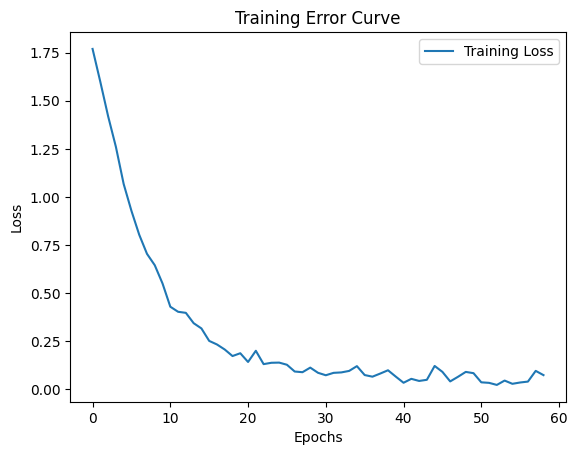


Test Accuracy: 0.6403


<Figure size 1200x1000 with 0 Axes>

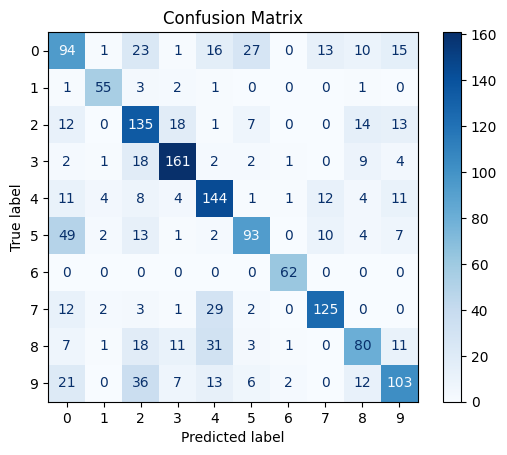

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# I also want to try 3 , 3 model
model = CNN_model(
    input_shape=(1, 128, 128),
    conv_layers=[16,32,64],
    fc_layers=[64,128,256],
    num_classes=10
).to(device)

model.initialize_weights()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
train_losses = []
model.train()
# Train for longer
epochs=60

for epoch in range(epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")

plt.plot(train_losses[1:], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Error Curve')
plt.legend()
plt.show()

model.eval() 
all_preds = []
all_labels = []

# Copy of the evalute of models
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)
        
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = accuracy_score(all_labels, all_preds)
print(f"\nTest Accuracy: {test_accuracy:.4f}")

classes = np.unique(all_labels)

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(12, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()

3 , 3 model got worse results than other models with 0.62 . Even though it had 60 epochs. 

### Summary

MLP models had 0.4 accuracy average of best and cnn models got 0.6+ results except for 1 , 1. Cnn imporoves the model so it is useful. Using some inception models or newer models and fine tuning could get good results. It needs to learn more local patterns and I got 128 X 128 input for convieneance but more data could be used from dataset. Using some data augmentation to make it more robest also.  